In [562]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from pandas import DataFrame, Series
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import platform
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

rfc = RandomForestRegressor()
xgb = XGBRegressor()
lr = LinearRegression()
lgbm = LGBMRegressor()
svc = LinearSVC()

In [563]:
y = pd.read_csv('./y_open_1min/y_open_0930', index_col=0)
X = pd.read_csv('./X_Features_ver2.csv')

# 시간 형태로 변경
X['date'] = pd.to_datetime(X['date'] ,format="%Y-%m-%d")
y['date'] = pd.to_datetime(y['date'],format= "%Y%m%d")

df = pd.merge(X,y, on='date',how='inner')
df.sort_index(inplace=True)


FileNotFoundError: [Errno 2] No such file or directory: './y_open_1min/y_open_0930.csv'

In [ ]:
df.drop(columns=['sp500_high','sp500_low','sp500_change_percentage','kodex_high', 'kodex_low', 'kodex_close',
        'kosdaq_open', 'kosdaq_high', 'kosdaq_low',
        'kosdaq_close'], inplace=True)

In [ ]:
df['sp500_closing'] = df['sp500_closing'].str.replace(',', '').astype(float)
df['sp500_opening'] = df['sp500_opening'].str.replace(',', '').astype(float)

In [ ]:
# y의 시점 변환
df['open']=df['open'].shift(-1)
df['kodex_open']=df['kodex_open'].shift(-1)


# index = date
df.set_index('date', inplace=True)
df.dropna(inplace=True)

# X, y 정의
y = df[['open']]
y.rename(columns={'open' : "target"})
X = df.drop(columns='open')

In [ ]:
df1 = df[['open', 'krx_diff', 'PER', 'GOLD_RETURN', 'SP_500_RETURN',
       'VIX_RETURN', 'USA_10Y', 'kodex_volume', 'kodex_open',
       'KODEX_return']]
np.abs(df1.corr()['open']).sort_values(ascending=False)

open             1.000000
kodex_open       0.998487
USA_10Y          0.679363
PER              0.561315
kodex_volume     0.369339
krx_diff         0.079994
VIX_RETURN       0.071642
SP_500_RETURN    0.051408
GOLD_RETURN      0.008697
KODEX_return     0.007256
Name: open, dtype: float64

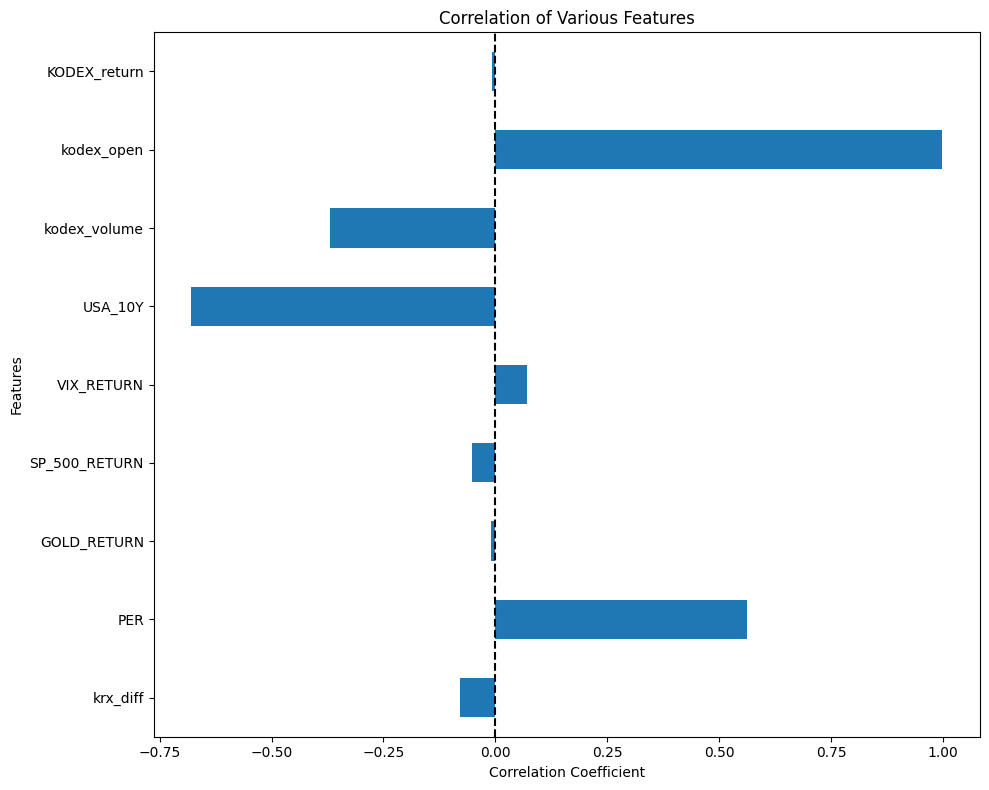

In [564]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df1.corr()

# Extract the 'krx_close' column's correlation values
krx_close_correlations = correlation_matrix['open'].drop('open')  # drop self-correlation

# Plot a horizontal bar chart for the 'krx_close' correlations
plt.figure(figsize=(10, 8))
krx_close_correlations.plot(kind='barh')  # Change to horizontal bar chart
plt.title('Correlation of Various Features')
plt.ylabel('Features')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='k', linestyle='--')  # Add a vertical line at zero
plt.tight_layout()  # Adjust the layout

# Show the plot
plt.show()

In [576]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
# df 날짜 정렬
df1.sort_index(inplace=True)
# X와 y 정의
X = df1.drop('open', axis=1)
y = df1['open']

# 분리 전 백테스트를 위한 date 생성
dates = df1.index

# 학습셋 분리 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.87, shuffle=False, random_state=42)


# StandardScaler객체 생성
scaler = MinMaxScaler()
# MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 모델
linear_regression_model = LinearRegression()

# Fit model
linear_regression_model.fit(X_train, y_train)

# Predict test
y_pred = linear_regression_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse ,"RMSE:", rmse, "r2_score:",r2)



MSE: 628752.7959843292 RMSE: 792.9393394102283 r2_score: 0.8377692060702996


In [ ]:
# 백테스트 날짜와 함께 결과 DataFrame 생성
results_df = pd.DataFrame({
    'date': dates[-len(y_pred):],  # 테스트 세트와 동일한 길이의 날짜 데이터
    'y_test': y_test.values,  # y_test를 1차원 배열로 변환
    'y_pred': y_pred  # y_pred는 이미 1차원 배열임
})
results_df.set_index('date', inplace=True)
mse, rmse, r2, results_df.head()


(17504.085909753656,
 132.30300793917596,
 0.9798510195562986,
              y_test        y_pred
 date                             
 2023-03-21  31213.0  31127.371770
 2023-03-22  31012.0  31026.498581
 2023-03-23  31144.0  31213.659593
 2023-03-24  31159.0  31133.764966
 2023-03-27  31390.0  31462.726903)

In [ ]:
backtest_open = pd.read_csv('./backtest_20/kodex_open.csv')
backtest_open['date'] = pd.to_datetime(backtest_open['date'],format= "%Y%m%d")
backtest_open.set_index('date', inplace=True)
backtest_open

,open
date,
2002-10-14,5354.0
2002-10-15,5483.0
2002-10-16,5442.0
2002-10-17,5661.0
2002-10-18,5729.0
...,...
2023-10-19,32175.0
2023-10-20,31905.0
2023-10-23,31920.0


In [ ]:
backtesting = pd.merge(results_df,backtest_open, right_index=True,left_index=True, how='inner')

In [ ]:
backtesting

,y_test,y_pred,open
date,,,
2023-03-21,31213.0,31127.371770,31213.0
2023-03-22,31012.0,31026.498581,31095.0
2023-03-23,31144.0,31213.659593,31410.0
2023-03-24,31159.0,31133.764966,31415.0
2023-03-27,31390.0,31462.726903,31277.0
...,...,...,...
2023-10-19,32905.0,32967.280747,32175.0
2023-10-20,32520.0,32769.697231,31905.0
2023-10-23,31945.0,32325.654174,31920.0


In [ ]:
backtesting.to_csv('./backtest_1min/back_test_0930.csv')

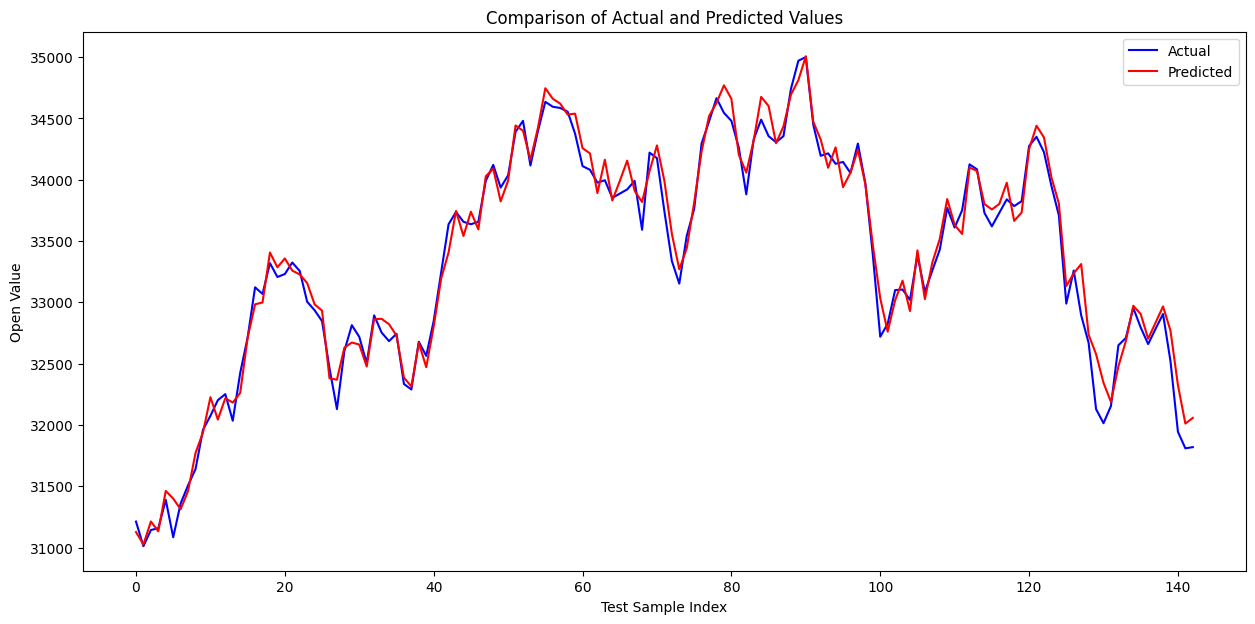

In [ ]:
import matplotlib.pyplot as plt

# 실제값과 예측값을 시각화하기 위한 인덱스 생성
test_indices = range(len(y_test))

plt.figure(figsize=(15, 7))
plt.plot(test_indices, y_test, label='Actual', color='blue')
plt.plot(test_indices, y_pred.flatten(), label='Predicted', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Open Value')
plt.legend()
plt.show()


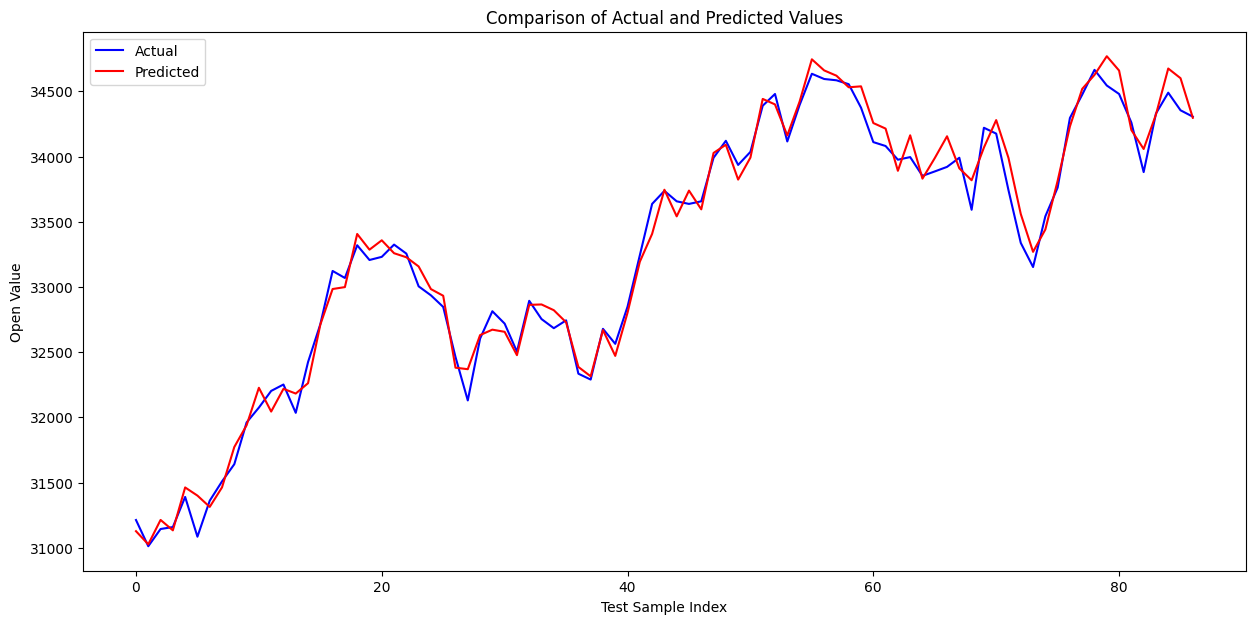

In [ ]:
# 실제값과 예측값을 시각화하기 위한 인덱스 생성
test_indices = range(len(y_test[:87]))

plt.figure(figsize=(15, 7))
plt.plot(test_indices, y_test[:87], label='Actual', color='blue')
plt.plot(test_indices, y_pred[:87].flatten(), label='Predicted', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Open Value')
plt.legend()
plt.show()


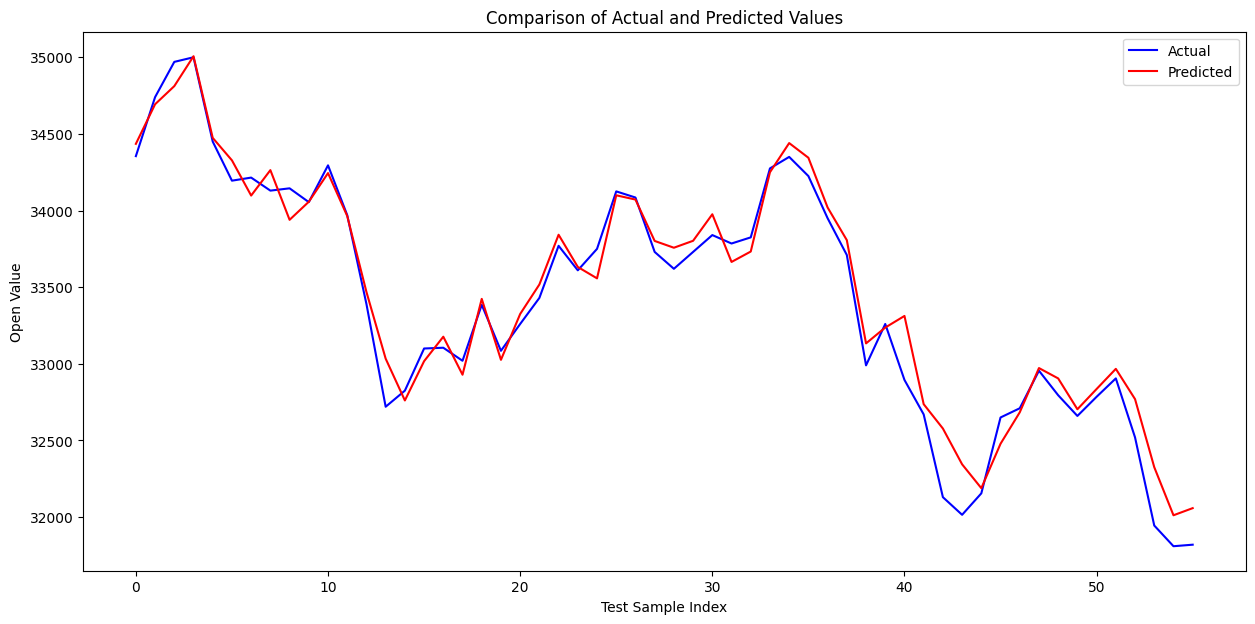

In [ ]:
# 실제값과 예측값을 시각화하기 위한 인덱스 생성
test_indices = range(len(y_test[87:174]))

plt.figure(figsize=(15, 7))
plt.plot(test_indices, y_test[87:174], label='Actual', color='blue')
plt.plot(test_indices, y_pred[87:174].flatten(), label='Predicted', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Open Value')
plt.legend()
plt.show()


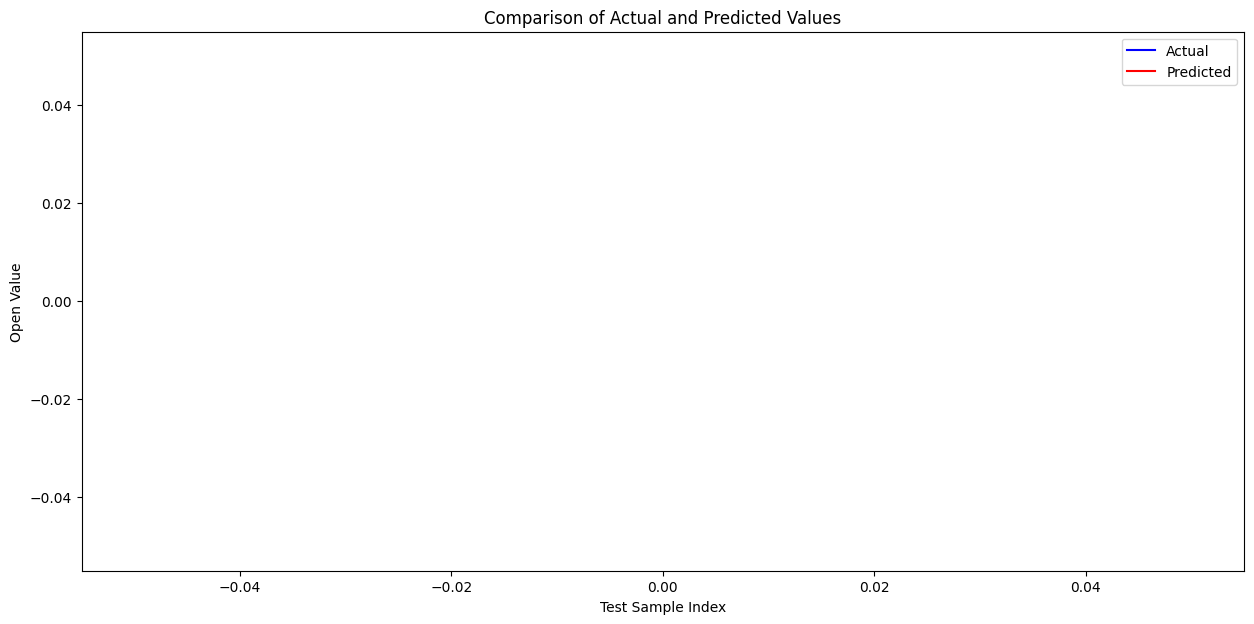

In [ ]:
# 실제값과 예측값을 시각화하기 위한 인덱스 생성
test_indices = range(len(y_test[174:261]))

plt.figure(figsize=(15, 7))
plt.plot(test_indices, y_test[174:261], label='Actual', color='blue')
plt.plot(test_indices, y_pred[174:261].flatten(), label='Predicted', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Open Value')
plt.legend()
plt.show()

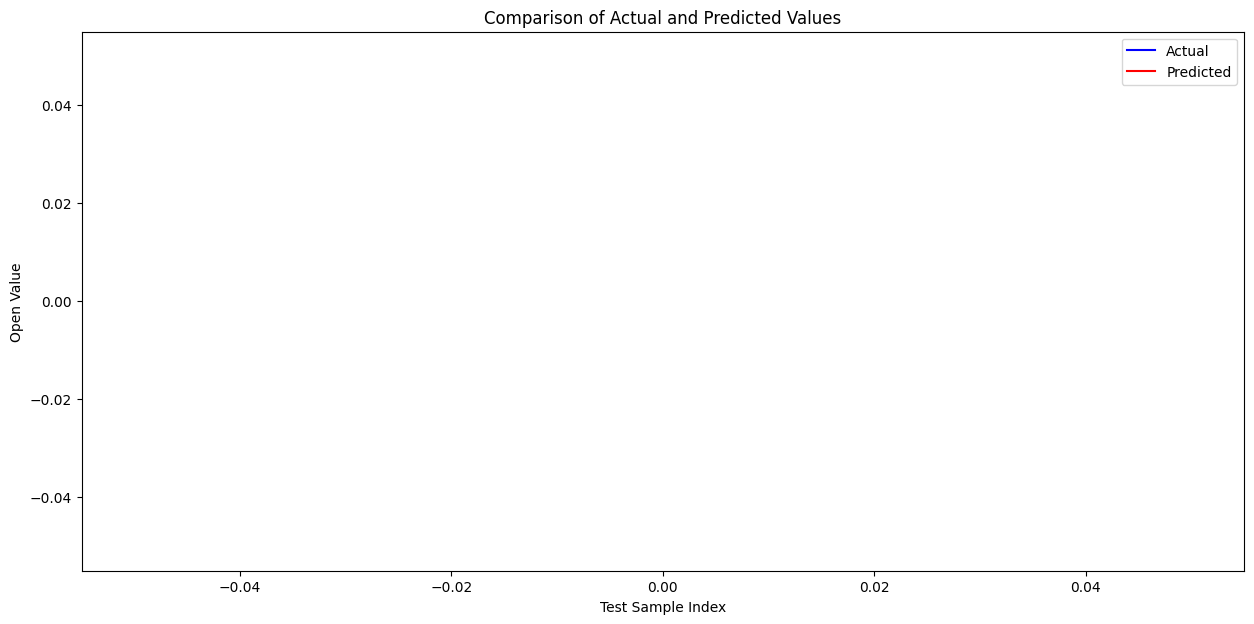

In [ ]:
# 실제값과 예측값을 시각화하기 위한 인덱스 생성
test_indices = range(len(y_test[261:350]))

plt.figure(figsize=(15, 7))
plt.plot(test_indices, y_test[261:350], label='Actual', color='blue')
plt.plot(test_indices, y_pred[261:350].flatten(), label='Predicted', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Open Value')
plt.legend()
plt.show()